# Pb from BC parameterization

Using only Alert, Nunavut observations (Sharma et al., 2019). https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JD030844

General source: World Database for Aerosols (https://www.gaw-wdca.org/). "As a general reference to the monitoring efforts and data contained in EBAS we suggest the paper http://www.atmos-chem-phys.net/12/5447/2012/acp-12-5447-2012.pdf "

#### Pb data
    - data type: arithmetic mean 
    - instrument type: high_vol_sampler (CA01L_HVS420_HM_MC) (https://amt.copernicus.org/preprints/amt-2016-12/amt-2016-12.pdf)
    - frequency: 1w
    - dates available: 1980-07-19 to 1995-05-22
    
#### Equivalent Black Carbon (EBC) data
    - data type: arithmetic mean, wavelength 820 
    - instrument type: filter_absorption_photometer (CA05L_Magee_Model_AE6) (https://psl.noaa.gov/iasoa/node/81) --> if anything, potentially biased high
    - frequency: 1h
    - dates available: 1989-05-29 to 1992-12-31, 2011-01-01 to 2012-12-29

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from matplotlib.dates import num2date
import matplotlib.dates as mdates
import datetime
import calendar
from scipy.optimize import leastsq
from scipy.stats import pearsonr
from scipy.signal import butter,filtfilt

%matplotlib inline

#### Parameters:

In [46]:
# Colors:
color_Pb      = '#625b62'
color_BC      = '#c9c9c9'
color_BC_line = '#a0a0a0'

# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

#### Load data

In [3]:
Alert     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Alert_1989-1992.nc')
Alert_EBC = Alert['EBC'].values*1e3 # ng/m3
Alert_EBC_dates = num2date(Alert['EBC_dates'].values)
Alert_Pb        = Alert['Pb'].values
Alert_Pb_dates  = num2date(Alert['Pb_dates'].values)

#### Functions

In [4]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

In [5]:
def lin_fit(x, y):
    '''Fits a linear fit of the form mx+b to the data'''
    fitfunc = lambda params, x: params[0] * x  
    errfunc = lambda p, x, y: fitfunc(p, x) - y              #create error function for least squares fit

    init_a = 0.5                            #find initial value for a (gradient)
    init_p = np.array((init_a))  #bundle initial values in initial parameters

    #calculate best fitting parameters (i.e. ) using the error function
    p1, success = leastsq(errfunc, init_p.copy(), args = (x, y))
    f = fitfunc(p1, x)          #create a fit with those parameters
    return p1, f  

In [6]:
def boxcar_filter_data(variable, sample_frequency='7d', window_len='5d'):
   
    # Calculate boxcar window length:
    if (window_len[-1] == 'd'):
        if (sample_frequency[-1] == 'd'): # units of days
            window_length = int(window_len[:-1]) / int(sample_frequency[:-1])
        elif (sample_frequency[-1] == 'h'): # units of hours
            window_length = int(window_len[:-1])*24 / int(sample_frequency[:-1])            
        else:
            prin('Sampling_frequency can only be in units of h (hours) or d (days)')
    else:
        print('Boxcar window_len can only be in units of d (days)')
        
    # Smooth data using window length: (based off Scipy recipe)
    #   Convolution of a scaled window with the signal. The signal is prepared by introducing reflected copies of the signal 
    #   (with the window size) in both ends.
    window_len = int(window_length)
    s          = np.r_[variable[window_len-1:0:-1], variable, variable[-2:-window_len-1:-1]]
    w          = np.ones(window_len,'d') # moving average:
    boxcar     = np.convolve(w / w.sum(), s, mode='valid')
    
    ind = int(np.floor(window_length/2))
    
    return boxcar[ind:-ind+1]

In [7]:
def resample_data(dates, variable, time_step='7d'):
    datetime_dates = [pd.to_datetime(date) for date in dates]
        
    # resample / interpolate data before applying filters so that they are evenly spaced to time_step size in days    
    if time_step[-1] == 'd':
        # units of days
        n_steps       = np.floor((datetime_dates[-1] - datetime_dates[0]).days / float(time_step[:-1])) # Number of time steps to apply
        gridded_dates = np.array([datetime_dates[0] + datetime.timedelta(days=int(time_step[:-1])*n) for n in range(int(n_steps))])
    elif time_step[-1] == 'h':
        # units of hours
        n_steps       = np.floor((datetime_dates[-1] - datetime_dates[0]).days*24 / float(time_step[:-1])) # Number of time steps to apply
        gridded_dates = np.array([datetime_dates[0] + datetime.timedelta(hours=int(time_step[:-1])*n) for n in range(int(n_steps))])
    else:
        print("Function is only set up for time_step units in d (days) or h (hour)")

    # convert dates to timestamps for interpolation
    timestamp_dates         = np.array([toTimestamp(t) for t in datetime_dates])
    timestamp_gridded_dates = np.array([toTimestamp(t) for t in gridded_dates])
    
    # interpolate dates:
    variable_gridded = np.interp(timestamp_gridded_dates, timestamp_dates, variable)

    return gridded_dates, variable_gridded

In [8]:
def match_dates(array1, array2, array1_dates, array2_dates):
    indx_array1 = np.array([])
    indx_array2 = np.array([])

    # Create arrays of the time periods when there are Pb and EBC data:
    for ind, date1 in enumerate(array1_dates):
        # Find index of nearest date for each measurement:
        difference = np.array([(date1 - date2).total_seconds() for date2 in array2_dates])
        indx_add = np.argmin(np.abs(difference))
        # Save indices to array:
        indx_array1  = np.append(indx_array1, int(ind))
        indx_array2  = np.append(indx_array2, int(indx_add))
        
    array1_dates_match = np.array([array1_dates[int(ix)] for ix in indx_array1])
    array1_match       = np.array([array1[int(ix)] for ix in indx_array1])
    array2_dates_match = np.array([array2_dates[int(ix)] for ix in indx_array2])
    array2_match       = np.array([array2[int(ix)] for ix in indx_array2])

    return array1_match, array2_match, array1_dates_match, array2_dates_match

#### Calculations

Subset to correct date range:

In [9]:
Alert_Pb_dates_subset  = Alert_Pb_dates[18:]
Alert_Pb_subset        = Alert_Pb[18:]
Alert_EBC_dates_subset = Alert_EBC_dates[:]
Alert_EBC_subset       = Alert_EBC[:]

Match nearest dates of measurements:

In [10]:
Alert_Pb_match, Alert_EBC_match, \
    Alert_Pb_dates_match, Alert_EBC_dates_match = match_dates(Alert_Pb_subset, Alert_EBC_subset, Alert_Pb_dates_subset, Alert_EBC_dates_subset)

Process / filter data:

In [25]:
# Grids are irregular, so interpolate to regular grid:
Alert_Pb_dates_gridded , Alert_Pb_gridded  = resample_data(Alert_Pb_dates_subset, Alert_Pb_subset, time_step='7d')   # Measured roughly weekly
Alert_EBC_dates_grid,    Alert_EBC_grid    = resample_data(Alert_EBC_dates_subset, Alert_EBC_subset, time_step='1h') # Measured roughly hourly

In [26]:
# Remove 1991-2-26 to 1991-3-11 from regridded dataset because no observations during this time period:
Alert_EBC_dates_gridded = Alert_EBC_dates_grid[(Alert_EBC_dates_grid < Alert_EBC_dates[11862]) \
                                                  | (Alert_EBC_dates_grid > Alert_EBC_dates[11863])]


Alert_EBC_gridded       = Alert_EBC_grid[(Alert_EBC_dates_grid < Alert_EBC_dates[11862]) \
                                                  | (Alert_EBC_dates_grid > Alert_EBC_dates[11863])]

In [34]:
Alert_Pb_boxcar  = boxcar_filter_data(Alert_Pb_gridded , sample_frequency='7d', window_len='30d')
Alert_EBC_boxcar = boxcar_filter_data(Alert_EBC_gridded, sample_frequency='1h', window_len='30d')

Correlate Pb:BC

In [49]:
# No Filtering
# Linear fit:
p1_start_Alert, f_start_Alert = lin_fit(Alert_EBC_match, Alert_Pb_match)
print(p1_start_Alert, 1/p1_start_Alert) # Pb = ratio*BC

[0.00787857] [126.92659615]


In [50]:
# Boxcar:
Alert_Pb_boxcar_match, Alert_EBC_boxcar_match, \
    Alert_Pb_dates_boxcar_match, Alert_EBC_dates_boxcar_match = match_dates(Alert_Pb_boxcar, Alert_EBC_boxcar, \
                                                                           Alert_Pb_dates_gridded, Alert_EBC_dates_gridded)

# Linear fit:
p1_boxcar_Alert, f_boxcar_Alert = lin_fit(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match)
print(p1_boxcar_Alert, 1/p1_boxcar_Alert) # Pb = ratio*BC

[0.01089848] [91.75595298]


#### Figures

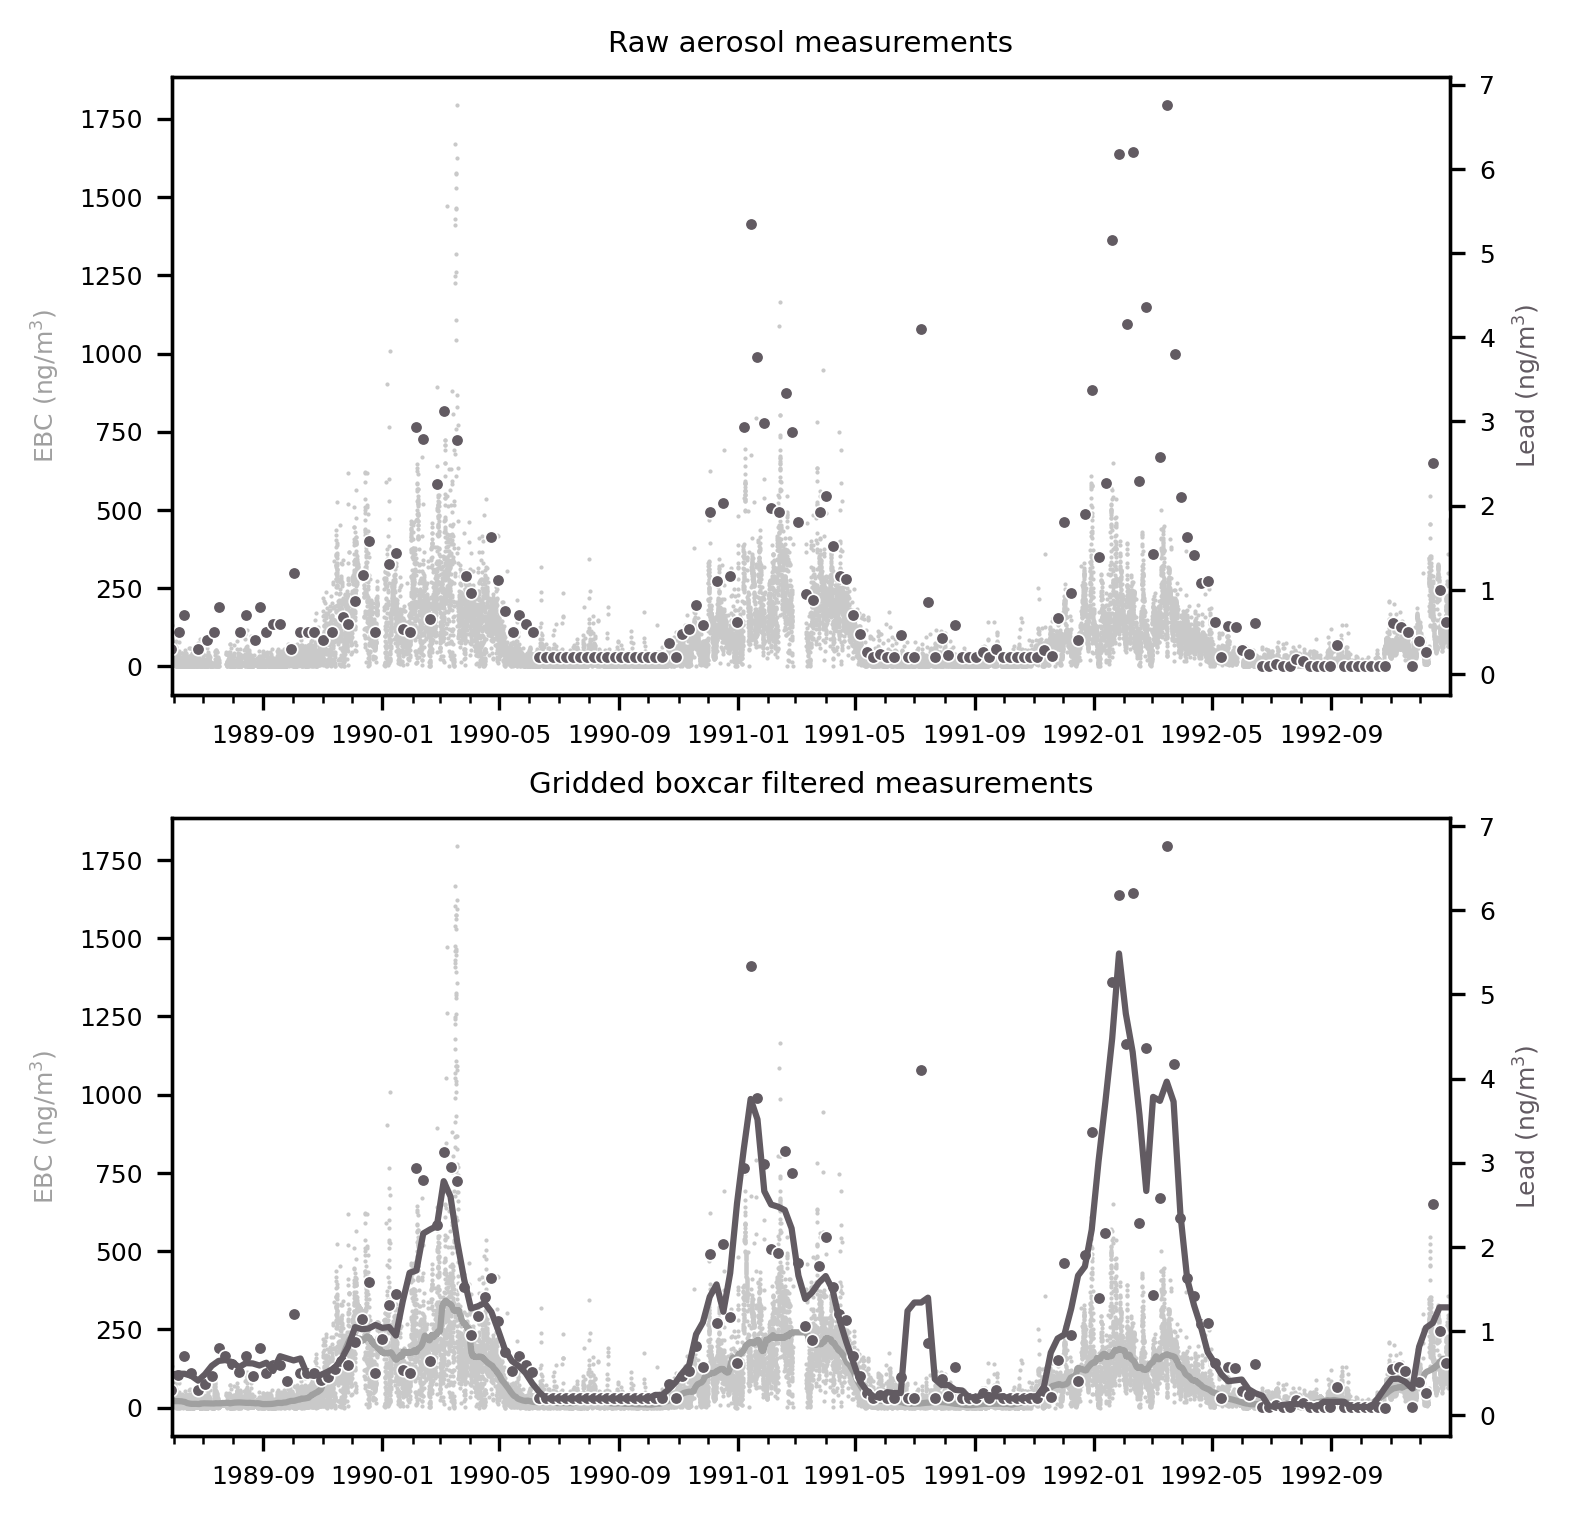

In [59]:
fig, ax = plt.subplots(2,1, figsize=(5.5, 6), dpi=300)

for axis in ax.ravel():
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_ylabel('EBC (ng/m$^3$)', fontsize=6, color=color_BC_line)
    axis.xaxis.set_minor_locator(mdates.MonthLocator())
    axis.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])
    
# Raw data -------------------------------
ax[0].set_title('Raw aerosol measurements', fontsize=7)
ax[0].plot_date(Alert_EBC_dates, Alert_EBC,'.', color=color_BC, markersize=1, markeredgewidth=0.5)
ax1 = ax[0].twinx()
ax1.plot_date(Alert_Pb_dates, Alert_Pb,'.', color=color_Pb, markersize=6, markeredgecolor='w', markeredgewidth=0.4)

# Boxcar filter --------------------------
ax[1].set_title('Gridded boxcar filtered measurements', fontsize=7)
ax[1].plot_date(Alert_EBC_dates_gridded, Alert_EBC_gridded,'.', color=color_BC, markersize=1, markeredgewidth=0.5)
ax[1].plot_date(Alert_EBC_dates_gridded, Alert_EBC_boxcar,'-', color=color_BC_line)
ax2 = ax[1].twinx()
ax2.plot_date(Alert_Pb_dates_gridded, Alert_Pb_gridded,'.', color=color_Pb, markersize=6, markeredgecolor='w', markeredgewidth=0.4)
ax2.plot_date(Alert_Pb_dates_gridded, Alert_Pb_boxcar,'-', color=color_Pb)

for axis in [ax1, ax2]:
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_ylabel('Lead (ng/m$^3$)', fontsize=6, color=color_Pb)
    axis.xaxis.set_minor_locator(mdates.MonthLocator())
    axis.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/raw_filtered_Pb-EBC_Alert.jpg', dpi=300, bbox_inches='tight')

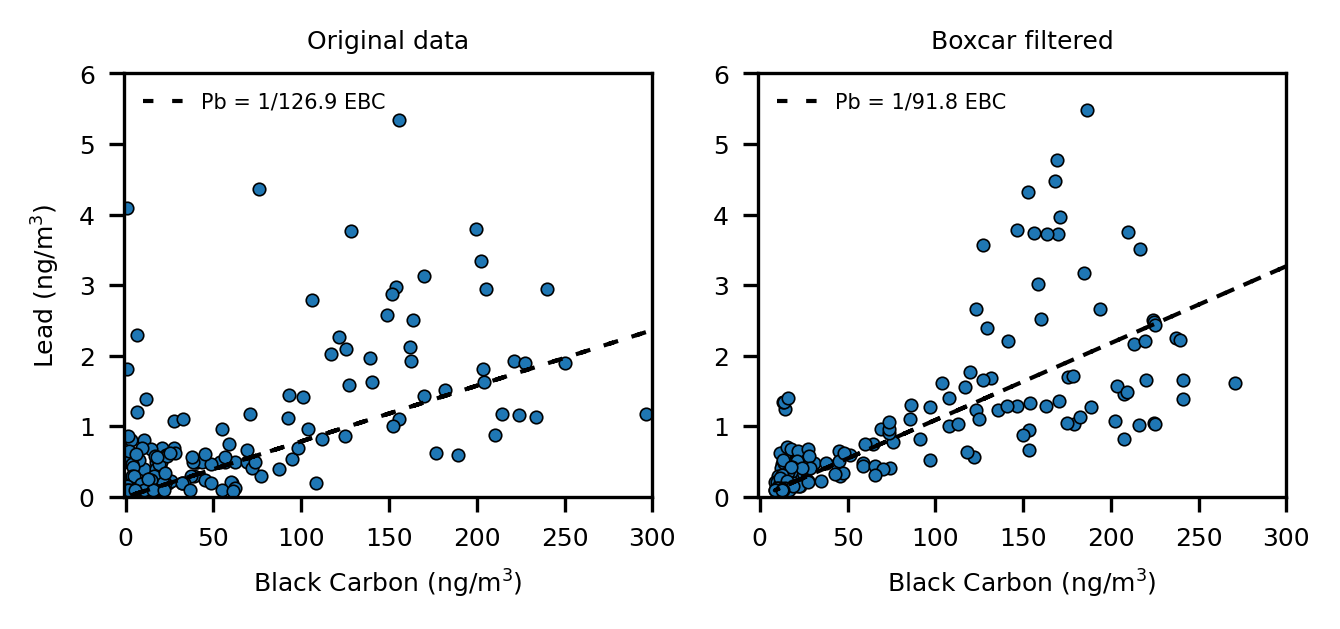

In [62]:
fig, ax = plt.subplots(1,2, figsize=(5, 3.74*0.5), dpi=300)

ax[0].plot(Alert_EBC_match, Alert_Pb_match, '.',  markersize=6, markeredgecolor='k', markeredgewidth=0.4)
ax[0].plot(Alert_EBC_match, f_start_Alert, '--k', linewidth=1.0, label=f'Pb = 1/{1/p1_start_Alert[0]:.1f} EBC', dashes=(2.5,4.5))
ax[0].set_ylabel('Lead (ng/m$^3$)', fontsize=6)
ax[0].set_title('Original data', fontsize=6)
ax[0].tick_params(axis='both', labelsize=6)
    
ax[1].plot(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match, '.',  markersize=6, markeredgecolor='k', markeredgewidth=0.4)
ax[1].plot(Alert_EBC_boxcar_match, f_boxcar_Alert, '--k', linewidth=1.0, label=f'Pb = 1/{1/p1_boxcar_Alert[0]:.1f} EBC', dashes=(2.5,4.5))
ax[1].set_title('Boxcar filtered', fontsize=6)
ax[1].tick_params(axis='both', labelsize=6)

for axis in ax.ravel():
    axis.set_xlim([-1, 300])
    axis.set_ylim([-0, 6])
    axis.set_xlabel('Black Carbon (ng/m$^3$)', fontsize=6)
    axis.legend(fontsize=5, loc=2, frameon=False)

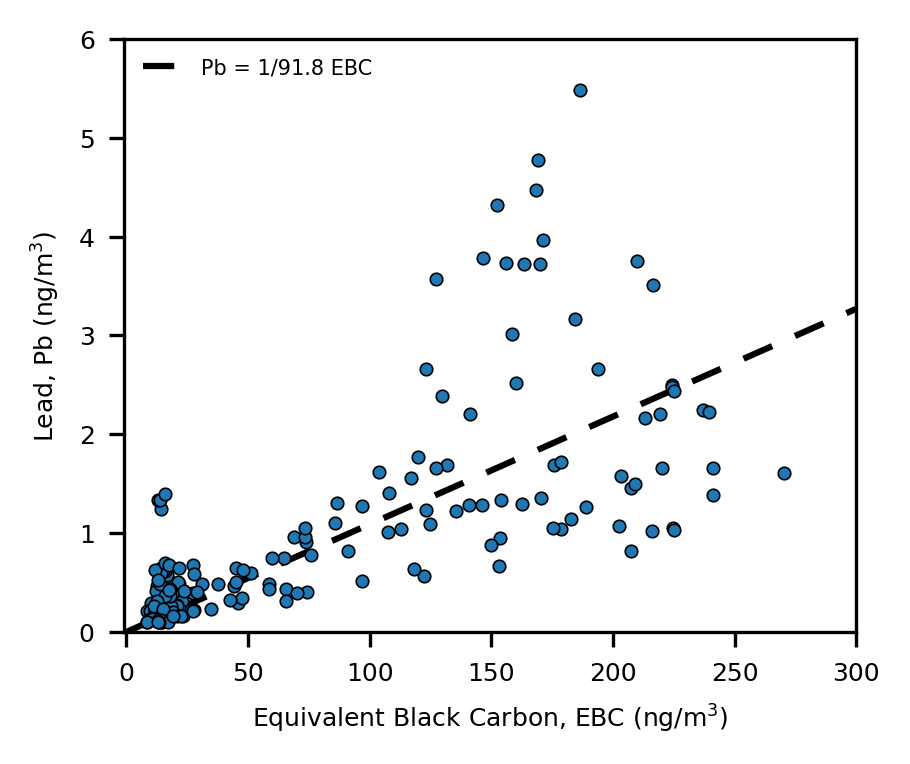

In [63]:
fig, ax = plt.subplots(1,1, figsize=(4.5*0.7, 3.74*0.7), dpi=300)

BC_array = np.linspace(0,300,50)    
ax.plot(BC_array, p1_boxcar_Alert*BC_array, '--k', linewidth=1.5, label=f'Pb = 1/{1/p1_boxcar_Alert[0]:.1f} EBC', dashes=(5,4))
ax.plot(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match, '.', markersize=6, markeredgecolor='k', markeredgewidth=0.4)
ax.tick_params(axis='both', labelsize=6)

ax.set_xlim([-1, 300])
ax.set_ylim([-0, 6.0])
ax.set_xlabel('Equivalent Black Carbon, EBC (ng/m$^3$)', fontsize=6)
ax.set_ylabel('Lead, Pb (ng/m$^3$)', fontsize=6)
ax.legend(fontsize=5, loc=2, frameon=False)


fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/Pb_EBC_ratio.jpg', dpi=300, bbox_inches='tight')

In [64]:
print('Correlation before any filtering is applied:')
print(f'Pearson r: {pearsonr(Alert_EBC_match, Alert_Pb_match)[0]:.2f}')

print('Correlation after boxcar filtering:')
print(f'Pearson r: {pearsonr(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match)[0]:.2f}')

Correlation before any filtering is applied:
Pearson r: 0.54
Correlation after boxcar filtering:
Pearson r: 0.72
